<a href="https://colab.research.google.com/github/johanhoffman/DD2365-VT20/blob/LindeBee/Project/ProjectV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The Stokes equations**
**Johan Hoffman**

# **Abstract**

This short report show an example on how to use FEniCS to solve the Stokes equations, which is used in the course DD2365 Advanced Computation in Fluid Mechanics, at the KTH Royal Institute of Technology.

[DD2365 course website.](https://kth.instructure.com/courses/17071)

# **About the code**

In [47]:
"""This program is an example file for the course"""
"""DD2365 Advanced Computation in Fluid Mechanics, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2020 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [0]:
# Load neccessary modules.
from google.colab import files

try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common 
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from dolfin import *; from mshr import *
    
import dolfin.common.plotting as fenicsplot
import math

from matplotlib import pyplot as plt

# **Introduction**

The Stokes equations take the form

$\nabla p -\Delta u = f,\quad \nabla \cdot u=0$

together with suitable boundary conditions.

Here we present a FEniCS implementation of a mixed finite element method to solve the Stokes equations in 2D. The solution is visualized using FEniCS plotting functions, and is also exported as pvd-files which can be visualized in Paraview.

To derive the weak form of the equations, multiply the momentum equation by $v\in V$ and the continuity equation by $q\in Q$, and then integrate over the domain $\Omega$ and use Green's formula
$
(\nabla p -\Delta u,v) = -(p,\nabla \cdot v) + (\nabla u, \nabla v) 
+ <pn - \nabla u\cdot n, v>_{\Gamma}
$

We seek a finite element approximation $(u,p)\in V\times Q$ such that 

$- (p,\nabla \cdot v) + (\nabla u,\nabla v) + (\nabla \cdot u, q) 
+ <pn - \nabla u\cdot n, v>_{\partial \Omega} = (f,v)$

for all test functions $(v,q) \in V\times Q$. 

$
(v,w) = \int_{\Omega} v\cdot w ~dx, \quad 
<v,w>_{\partial \Omega} = \int_{\partial \Omega} v\cdot w~ds
$

We divide the boundary into $\partial \Omega=\Gamma_D \cup \Gamma_N$, with the different boundary conditions

$
u = g_D,\quad x\in \Gamma_D,
$

$
-\nu \nabla u\cdot n + pn = g_N, \quad x\in \Gamma_N,
$

For $x\in \Gamma_D$ the test function $v=0$. Hence, with $g_N=0$ the boundary term is zero. 

The equations can be expressed in residual form

$r(u,p;v,q) = - (p,\nabla \cdot v) + (\nabla u,\nabla v) + (\nabla \cdot u, q) - (f,v)$

We use inf-sup stable Taylor-Hood approximation spaces, 
and to implement the velocity boundary conditions we use a penalty formulation, with a penalty parameter $\gamma = C/h$, with $C>0$ a constant and $h$ the local mesh size. At outflow we use a "do nothing" stress free boundary condition. 


# **Method**

**Define domain and mesh**

In [0]:
def grid():
  domain = Rectangle(Point(0,0), Point(L,H)) - Rectangle(Point(1.57,1.57), Point(10.43,10.43))

  for i in range (1,4):
    a = 1.57+i*((8.86+0.8)/4)
    domain += Rectangle(Point(a-0.8,1), Point(a,11))
    domain += Rectangle(Point(1,a-0.8), Point(11,a))

  # domain += Rectangle(Point(0,5), Point(12,5.5))
  
  return domain

def skewed():
  domain = Rectangle(Point(0,0), Point(12,12))
  alpha = math.radians(35)
  str_w = 0.6
  shape_w = 1.2
  shape_h = shape_w*tan(alpha)
  dhor= str_w/(cos(alpha)*sin(alpha))
  dver = str_w/(2*cos(alpha))
  print(shape_h)
  for i in range (0,7):
    a = 2.5
    b = 1.57+i*(shape_h+dver)
    if (i%2 == 0):
        num_shapes = 3
    else:
        num_shapes = 2
        a += (shape_w+dhor/2)
    for j in range(0,num_shapes):
      domain -= Polygon([Point(a,b),Point(a+shape_w,b+shape_h),Point(a,b+2*shape_h),Point(a-shape_w,b+shape_h)])
      a += 2*shape_w + dhor
  
  
  # domain += (Rectangle(Point(0,0), Point(L,H)) - Rectangle(Point(1,1), Point(11,11)))
  # domain -= (Rectangle(Point(0,-5.5),Point(12,0)))
  # domain -= (Rectangle(Point(0,12), Point(12,20)))
  return domain

# domain = skewed()


def concentric():
  domain = Rectangle(Point(0,0), Point(L,H))
  
  for i in range (0,12):
    alpha = i*2*pi/12
    beta = (i+1)*2*pi/12#-(0.2*6)
    domain -= Polygon([Point(6+5*cos(alpha), 6+5*sin(alpha)),Point(6+5*cos(beta), 6+5*sin(beta)),Point(6+3*cos(beta), 6+3*sin(beta)),Point(6+3*cos(alpha), 6+3*sin(alpha))])

  for i in range (0,12):
    alpha = i*2*pi/12
    dx = cos(alpha-pi/2) * 0.4
    dy = sin(alpha-pi/2) * 0.4
    domain += Polygon([Point(6+6*cos(alpha)+dx,6+6*sin(alpha)+dy),Point(6+6*cos(alpha)-dx,6+6*sin(alpha)-dy),Point(6-dx,6-dy),Point(6+dx,6+dy)])

  domain -= Circle(Point(6,6), 2.0)

  for i in range (0,4):
    alpha = i*2*pi/4
    dx = cos(alpha-pi/2) * 0.4
    dy = sin(alpha-pi/2) * 0.4
    domain += Polygon([Point(6+2.6*cos(alpha)+dx,6+2.6*sin(alpha)+dy),Point(6+2.6*cos(alpha)-dx,6+2.6*sin(alpha)-dy),Point(6-dx,6-dy),Point(6+dx,6+dy)])

  return domain

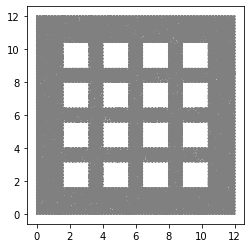

In [50]:
# Define rectangular domain 
L = 12
H = 12

# Define subdomains (for boundary conditions)
class Left(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 0.0) 

class Right(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], L)

class Lower(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 0.0)

class Upper(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], H)

class Inlet(SubDomain):
    def inside(self, x, on_boundary):
        on = near(x[0], 0.0) or near(x[1], 0.0)
        return on

class Outlet(SubDomain):
    def inside(self, x, on_boundary):
        on = near(x[0], L) or near(x[1], H)
        return on

class Building(SubDomain):
    def inside(self, x, on_boundary):
        on = (on_boundary and not (near(x[0],0.0) or near(x[0], L)\
                                    or near(x[1], 0.0) or near(x[1],H)))
        return on
      
building = Building()
inlet_bdry = Inlet()
outlet_bdry = Outlet()

#files to save meshes
saved_grid = File("grid.xml")
saved_skewed = File("skewed.xml")
saved_circle = File("circle.xml")

# Generate mesh (uncomment choice) 
resolution = 64

# grid mesh
try:
  saved_grid >> mesh
except:
  domain = grid()
  mesh = generate_mesh(domain, resolution)
  saved_grid << mesh

# skewed mesh
# try:
#   saved_skewed >> mesh
# except:
#   domain = skewed()
#   mesh = generate_mesh(domain, resolution)
#   saved_skewed << mesh

# circular mesh
# try:
#   saved_circle >> mesh
# except:
#   domain = concentric()
#   mesh = generate_mesh(domain, resolution)
#   saved_circle << mesh

# Local mesh refinement (specified by a cell marker)
no_levels = 0
for i in range(0,no_levels):
  cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
  for cell in cells(mesh):
    cell_marker[cell] = False
    p = cell.midpoint()
    if p.distance(Point(xc, yc)) < 1.0:
        cell_marker[cell] = True
  mesh = refine(mesh, cell_marker)

# Define mesh functions (for boundary conditions)
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
boundaries.set_all(0)
inlet_bdry.mark(boundaries, 1)
outlet_bdry.mark(boundaries, 2)
building.mark(boundaries, 3)

# for visualisation of different boundaries
# file = File("bres/boundaries.pvd")
# file << boundaries
# !tar -czvf bres.tar.gz bres

plt.figure()
plot(mesh)
plt.show()

**Define finite element approximation spaces**

In [0]:
# Generate mixed finite element spaces (for velocity and pressure)
VE = VectorElement("CG", mesh.ufl_cell(), 2)
QE = FiniteElement("CG", mesh.ufl_cell(), 1)
WE = VE * QE

W = FunctionSpace(mesh, WE)
V = FunctionSpace(mesh, VE)
Q = FunctionSpace(mesh, QE)

# Define trial and test functions
w = Function(W)
(u, p) = (as_vector((w[0],w[1])), w[2])
(v, q) = TestFunctions(W) 

**Define boundary conditions**

In [0]:
# inflow and outflow conditions
XMIN = 0.0; XMAX = L
YMIN = 0.0; YMAX = H
uin = Expression(("1.", ".5"), YMAX=YMAX, element = V.ufl_element()) 
#pout = 0.0

# Inflow boundary (ib), outflow boundary (ob) and wall boundary (wb)
ib = Expression("near(x[0],XMIN) || near(x[1],YMIN) ? 1. : 0.", XMIN=XMIN, YMIN=YMIN, element = Q.ufl_element())
ob = Expression("near(x[0],XMAX) || near(x[1], YMAX) ? 1. : 0.", XMAX=XMAX, YMAX=YMAX, element = Q.ufl_element()) 
wb = Expression("x[0] > XMIN + DOLFIN_EPS && x[0] < XMAX - DOLFIN_EPS && x[1] > YMIN + DOLFIN_EPS && x[1] < YMAX - DOLFIN_EPS? 1. : 0.", XMIN=XMIN, XMAX=XMAX, YMIN=YMIN,YMAX=YMAX, element = Q.ufl_element())

# **Results**

**Define and solve variational problem for velocity field**





In [0]:
h = CellDiameter(mesh)
C = 1.0e3
gamma = C/h

n = FacetNormal(mesh)
f = Expression(("0.0","0.0"), element = V.ufl_element())

# Define variational problem on residual form: r(u,p;v,q) = 0
residual = ( - p*div(v)*dx + inner(grad(u), grad(v))*dx + div(u)*q*dx + 
            gamma*(ib*inner(u - uin, v) + wb*inner(dot(u,n), dot(v,n)))*ds - inner(f, v)*dx )

# Solve algebraic system 
solve(residual == 0, w) 

**Visualize solution and export files**

rm: cannot remove 'results-NS/*': No such file or directory


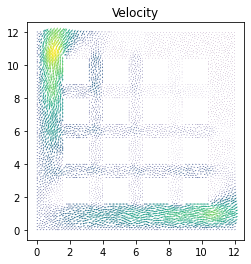

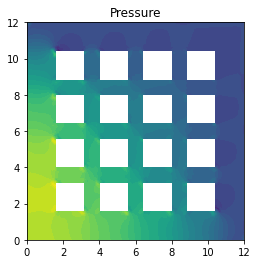

In [54]:
!rm results-NS/*

# Open files to export solution to Paraview
file_u = File("results-Stokes/u.pvd")
file_p = File("results-Etokes/p.pvd")

u1 = project(u, V)
p1 = project(p, Q)

# Save solution to file
file_u << u1
file_p << p1

# Plot solution
plt.figure()
plot(u1, title="Velocity")

plt.figure()
plot(p1, title="Pressure")
        
plt.show()

# Export files
#!tar -czvf results-Stokes.tar.gz results-NS
#files.download('results-Stokes.tar.gz')

**Time stepping for pollution concentration**

In [55]:
# Define function space for system of concentrations
element = FiniteElement("P", triangle, 1)
Vc = FunctionSpace(mesh, element)

vc = TestFunctions(Vc) #test function
fc = Constant(0.1)    #source
dt = 0.5*mesh.hmin()  #time step
k = Constant(dt)
c = Function(Vc)       #concentration
c_n = Function(Vc)     #concentration previous timestep

#variational problem:
F = ((c-c_n)/k)*vc*dx  + (u+grad(c))*vc*dx \
+ dot(fc*u,grad(c))*dot(u,grad(vc))*dx - fc*vc*dx

#time stepping
file_c = File("results/c.pvd")
t=0
num_steps = int(5/dt)
for n in range(num_steps):
    print(n+"\n")
    # Update current time
    t += dt
    # Solve variational problem for time step
    solve(F == 0, c)
    # Save solution to file (VTK)
    file_c << (c, t)
    # Update previous solution
    uc_n.assign(uc)

# Plot solution
c1 = project(c, Vc)
plt.figure()
plot(c1, title="Concentration")
plt.show()


TypeError: ignored

# **Discussion**

A Taylor-Hood mixed finite element method was implemented in FEniCS to solve the Stokes equations in 2D. The method was tested for the model problem of flow past a number of circular obstacles, and the solution behaved as expected.  